In [1]:
import torch
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from gurobipy import GRB, quicksum, Model
from math import ceil

# Lagrangian Dual of LP with Bound Constraints
The linear program that will be tackled is of the form:

minimize $c^Tx$

subject to $Ax\geq b,-e\leq x \leq e, (||x||_\infty \leq 1)$

The problem to solve is: 

$\phi(\lambda) = \inf_{-e\leq x \leq e} L(x, \lambda) = \inf_{-e \leq x \leq e} [(c - A^T \lambda )^T x + b^T \lambda ]$

In the equation above, if $(c - A^T\lambda)_j \leq 0, x_j = 1$, otherwise $x_j = -1$, where j denotes the jth inequality constraint. 

Therefore the Lagrangian dual is:

maximize $b^T\lambda - ||c - A^T\lambda||_1$

subject to $\lambda \in \mathbb{R}^m$

For the examples below, we will use the above setup including the bounds on x. To obtain the optimal Lagrange multipliers, we use the PyTorch Adam optimizer to maximimize the Lagrangian dual, and then obtain the lower bound by plugging in these multipliers into the dual objective at the end. 

The only difference in each example is the inequality constraints. 

Our variables are defined as: 

$$x = \begin{pmatrix}x_1\\x_2\end{pmatrix}$$
$$c \begin{pmatrix}1\\1\end{pmatrix}$$
$$\lambda \in \mathbb{R}^1$$
$$A \in \mathbb{R}^{1x2}$$
$$b \in \mathbb{R}^1$$

Naturally, this means the objective function to minimize is $x_1 + x_2$ subject to some constraints. 

In [2]:
def langrange_dual_fn (e_x, A, c, b, lambda_):
    x = torch.abs(e_x).float() # ensure x is positive
    return -1*torch.abs((c - A.T@lambda_).T@x) + b.T@lambda_

def maximizing_fn (A, b, c, lambda_, alpha = 1):
    return b.T @ lambda_ - torch.norm(alpha * c-A.T@lambda_, p=1)

In [3]:
num_steps = 100
lr = 0.1

### Example 1
$-x_1 - x_2 \leq 0.5$

In [4]:
A_t = torch.tensor([[1.,1.]])
c_t = torch.tensor([[1.],[1.]])
b_t = torch.tensor([[-0.5]])
x_t = torch.tensor([[1.],[1.]])
lambda_ = torch.rand(1,1, requires_grad=True)

opt = torch.optim.Adam([lambda_], lr=lr, maximize=True)

for step in range(num_steps):
    y = maximizing_fn(A_t, b_t, c_t, lambda_)

    opt.zero_grad(set_to_none=True)
    y.backward()
    opt.step()

    with torch.no_grad():
        lambda_.data = torch.clamp(lambda_.data, min=0.0)

lambda_optimized = lambda_.data
print(f"Optimized lambda: \n{lambda_.data}")
print(f"Lower bound: \n{langrange_dual_fn(x_t, A_t, c_t, b_t, lambda_).data}")

Optimized lambda: 
tensor([[1.0012]])
Lower bound: 
tensor([[-0.5029]])


### Example 2
$-x_1 - x_2 \geq 0.5$

In [5]:
A_t = torch.tensor([[-1.,-1.]])
c_t = torch.tensor([[1.],[1.]])
b_t = torch.tensor([[0.5]])
x_t = torch.tensor([[1.],[1.]])
lambda_ = torch.rand(1,1, requires_grad=True)

opt = torch.optim.Adam([lambda_], lr=lr, maximize=True)

for step in range(num_steps):
    # y = maximizing_fn(A_t, b_t, c_t, lambda_)
    y = langrange_dual_fn(x_t, A_t, c_t, b_t, lambda_)

    opt.zero_grad(set_to_none=True)
    y.backward()
    opt.step()

    with torch.no_grad():
        lambda_.data = torch.clamp(lambda_.data, min=0.0)

lambda_optimized = lambda_.data
print(f"Optimized lambda: \n{lambda_.data}")
print(f"Lower bound: \n{langrange_dual_fn(x_t, A_t, c_t, b_t, lambda_).data}")

Optimized lambda: 
tensor([[0.]])
Lower bound: 
tensor([[-2.]])


### Example 3
$x_1 + x_2 \geq 0$

In [6]:
A_t = torch.tensor([[1.,1.]])
c_t = torch.tensor([[1.],[1.]])
b_t = torch.tensor([[0.]])
x_t = torch.tensor([[1.],[1.]])
lambda_ = torch.rand(1,1, requires_grad=True)

opt = torch.optim.Adam([lambda_], lr=lr, maximize=True)

for step in range(num_steps):
    # y = maximizing_fn(A_t, b_t, c_t, lambda_)
    y = langrange_dual_fn(x_t, A_t, c_t, b_t, lambda_)

    opt.zero_grad(set_to_none=True)
    y.backward()
    opt.step()

    with torch.no_grad():
        lambda_.data = torch.clamp(lambda_.data, min=0.0)

lambda_optimized = lambda_.data
print(f"Optimized lambda: \n{lambda_.data}")
print(f"Lower bound: \n{langrange_dual_fn(x_t, A_t, c_t, b_t, lambda_).data}")

Optimized lambda: 
tensor([[0.9947]])
Lower bound: 
tensor([[-0.0105]])


### Example 4
$x_1 + x_2 \geq 1$

In [7]:
A_t = torch.tensor([[1.,1.]])
c_t = torch.tensor([[1.],[1.]])
b_t = torch.tensor([[1.]])
x_t = torch.tensor([[1.],[1.]])
lambda_ = torch.rand(1,1, requires_grad=True)

opt = torch.optim.Adam([lambda_], lr=lr, maximize=True)

for step in range(num_steps):
    # y = maximizing_fn(A_t, b_t, c_t, lambda_)
    y = langrange_dual_fn(x_t, A_t, c_t, b_t, lambda_)

    opt.zero_grad(set_to_none=True)
    y.backward()
    opt.step()

    with torch.no_grad():
        lambda_.data = torch.clamp(lambda_.data, min=0.0)

lambda_optimized = lambda_.data
print(f"Optimized lambda: \n{lambda_.data}")
print(f"Lower bound: \n{langrange_dual_fn(x_t, A_t, c_t, b_t, lambda_).data}")

Optimized lambda: 
tensor([[1.0369]])
Lower bound: 
tensor([[0.9631]])


### Example 5
$x_1 + x_2 \geq -1$

In [8]:
A_t = torch.tensor([[1.,1.]])
c_t = torch.tensor([[1.],[1.]])
b_t = torch.tensor([[-1.]])
x_t = torch.tensor([[1.],[1.]])
lambda_ = torch.rand(1,1, requires_grad=True)

opt = torch.optim.Adam([lambda_], lr=lr, maximize=True)

for step in range(num_steps):
    # y = maximizing_fn(A_t, b_t, c_t, lambda_)
    y = langrange_dual_fn(x_t, A_t, c_t, b_t, lambda_)

    opt.zero_grad(set_to_none=True)
    y.backward()
    opt.step()

    with torch.no_grad():
        lambda_.data = torch.clamp(lambda_.data, min=0.0)

lambda_optimized = lambda_.data
print(f"Optimized lambda: \n{lambda_.data}")
print(f"Lower bound: \n{langrange_dual_fn(x_t, A_t, c_t, b_t, lambda_).data}")

Optimized lambda: 
tensor([[0.9803]])
Lower bound: 
tensor([[-1.0197]])


In [9]:
A_t = torch.tensor([[1.,1.]])
c_t = torch.tensor([[-1.],[-1.]])
b_t = torch.tensor([[-1.]])
x_t = torch.tensor([[1.],[1.]])
lambda_ = torch.rand(1,1, requires_grad=True)

opt = torch.optim.Adam([lambda_], lr=lr, maximize=True)

for step in range(num_steps):
    # y = maximizing_fn(A_t, b_t, c_t, lambda_)
    y = langrange_dual_fn(x_t, A_t, c_t, b_t, lambda_)

    opt.zero_grad(set_to_none=True)
    y.backward()
    opt.step()

    with torch.no_grad():
        lambda_.data = torch.clamp(lambda_.data, min=0.0)

lambda_optimized = lambda_.data
print(f"Optimized lambda: \n{lambda_.data}")
print(f"Lower bound: \n{langrange_dual_fn(x_t, A_t, c_t, b_t, lambda_).data}")

Optimized lambda: 
tensor([[0.]])
Lower bound: 
tensor([[-2.]])


Final example with many constraints

In [10]:
c_t = torch.tensor([[1.],[1.]])
G_t = -1*torch.tensor([[-2/9, 1],[-6/5, 1], [-5/3, -1], [1/8, -1], [5, 1]]).float()
h_t = -1*torch.tensor([[46/9], [6], [25/3], [19/4], [26]]).float()
G_t = -1*torch.tensor([[-5/3, -1]]).float()
h_t = -1*torch.tensor([[25/3]]).float()
x_t = torch.tensor([[-5.],[-5.]])
lambda_ = torch.rand(1,1, requires_grad=True)
# alpha = torch.rand(1, requires_grad=True)
alpha = torch.tensor([[1.]])

opt = torch.optim.Adam([lambda_, alpha], lr=lr, maximize=True)

num_steps = 100

for step in range(num_steps):
    y = maximizing_fn(G_t, h_t, c_t, lambda_, alpha)
    # y = langrange_dual_fn(x_t, G_t, c_t, h_t, lambda_)

    opt.zero_grad(set_to_none=True)
    y.backward()
    opt.step()

    with torch.no_grad():
        lambda_.data = torch.clamp(lambda_.data, min=0.0)
        alpha.data = torch.clamp(alpha.data, min=0.0, max=1.0)

lambda_optimized = lambda_.data
print(f"Optimized lambda: \n{lambda_.data}")
print(f"Lower bound: \n{langrange_dual_fn(x_t, G_t, alpha*c_t, h_t, lambda_).data}")

Optimized lambda: 
tensor([[0.]])
Lower bound: 
tensor([[-10.]])


Now consider a problem with 2 bounds:

In [11]:
opt_mod = Model(name="Multi_bound")

# constraints
G = np.array([[5/3, 1], [-1/8, 1]])
h = np.array([[-25/3], [-19/4]])

x = opt_mod.addMVar(shape=(2,1), name='x', lb=-5, ub=5)

# adding constraints
ineq_c = opt_mod.addConstr(G @ x >= h, name='c0')

# add objective
alpha = 0.5
c = np.array([[1],[1]]) * alpha

opt_mod.setObjective(c.T@x, GRB.MINIMIZE)

opt_mod.optimize()

# output the result
print('Objective Function Value: %f' % opt_mod.ObjVal)
# Get values of the decision variables
for v in opt_mod.getVars():
    print('%s: %g' % (v.VarName, v.x))

ineq_pi = ineq_c.Pi
print(f"Printing inequality constraint dual variables:\n {ineq_pi}")

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 2 rows, 2 columns and 4 nonzeros
Model fingerprint: 0x43bddeaf
Coefficient statistics:
  Matrix range     [1e-01, 2e+00]
  Objective range  [5e-01, 5e-01]
  Bounds range     [5e+00, 5e+00]
  RHS range        [5e+00, 8e+00]
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.8333333e+00   1.210417e+01   0.000000e+00      0s
       1   -3.5000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.00 seconds (0.00 work units)
Optimal objective -3.500000000e+00
Objective Function Value: -3.500000
x[0,0]: -2
x[1,0]: -5
Printing inequality constraint dual variables:
 [[0.3]
 [

In [12]:
# # plug this solution back in 
eps = np.array([[5], [5]])
sol = -1 * np.abs(c - G.T@ineq_pi).T@eps + h.T @ ineq_pi
sol = np.squeeze(sol)
print(sol)

-3.5


In [13]:
def langrange_dual_fn (e_x, A, c, b, lambda_):
    x = torch.abs(e_x).float() # ensure x is positive
    return -1*torch.abs((c - A.T@lambda_).T)@x + b.T@lambda_

Shape lambda_vals (5, 50)
Optimized lambda: 
tensor([[0.2927],
        [0.0052],
        [0.0000]])
[0.2927065  0.00522431 0.        ]
Lower bound: 
tensor([[-3.5384]])
Max Loss: -3.504701614379883


/tmp/ipykernel_6629/1842205810.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lambda_vals[-1, step] = alpha.data.detach().clone().numpy().flatten()


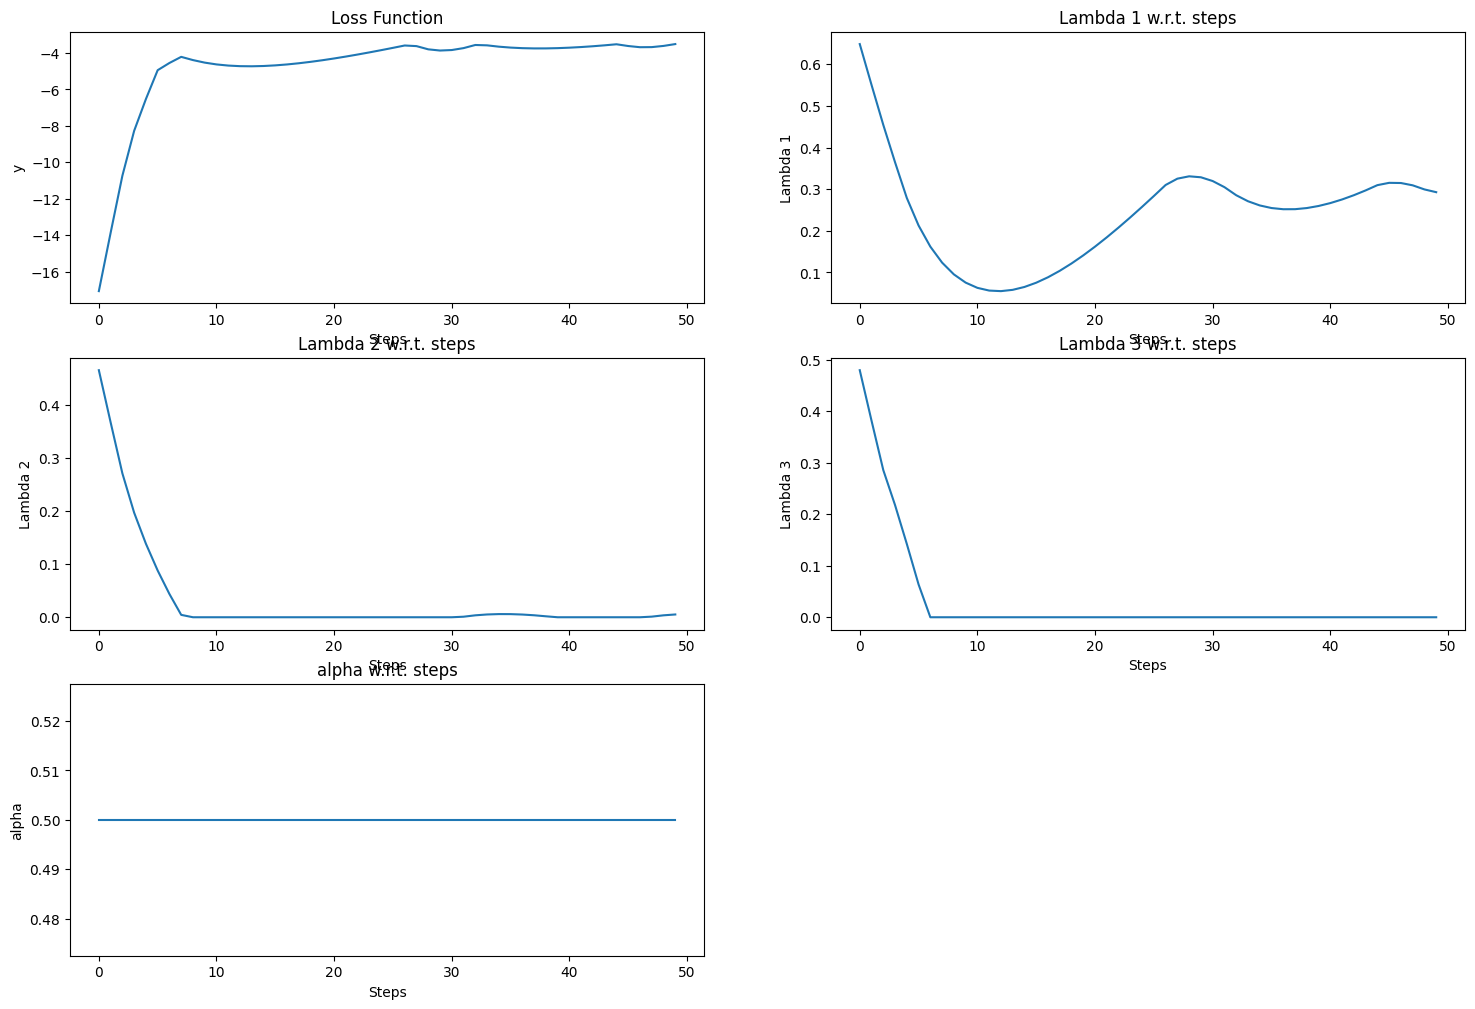

In [28]:
# alpha = torch.rand(1, requires_grad=True)
alpha = torch.tensor(0.5)
c_t = torch.tensor([[1.],[1.]])
G_t = torch.tensor([[5/3, 1], [-1/8, 1], [2/9, -1]])
h_t = torch.tensor([[-25/3], [-19/4], [-46/9]])
x_t = torch.tensor([[-5.],[-5.]])
lambda_ = torch.rand(3,1, requires_grad=True)

opt = torch.optim.Adam([lambda_], lr=lr, maximize=True)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, 0.98)

num_steps = 50

loss_graph = np.array([i for i in range(num_steps)], dtype=np.float32)
loss_graph = np.vstack((loss_graph, np.zeros(num_steps)))
lambda_vals = np.array([i for i in range(num_steps)], dtype=np.float32)
lambda_vals = np.tile(lambda_vals, lambda_.shape[0] + 2).reshape(-1, num_steps)
print(f"Shape lambda_vals {lambda_vals.shape}")

for step in range(num_steps):
    y = langrange_dual_fn(x_t, G_t, c_t*alpha, h_t, lambda_)
    loss_graph[1, step] = y.item()

    opt.zero_grad(set_to_none=True)
    y.backward()
    opt.step()
    scheduler.step()

    with torch.no_grad():
        lambda_.data = torch.clamp(lambda_.data, min=0.0)
        alpha.data = torch.clamp(alpha.data, min=0.0, max=1.0)
        lambda_vals[1:-1, step] = lambda_.data.detach().clone().numpy().flatten()
        lambda_vals[-1, step] = alpha.data.detach().clone().numpy().flatten()

lambda_optimized = lambda_.data
print(f"Optimized lambda: \n{lambda_.data}")
print(lambda_.data.detach().clone().numpy().flatten())
print(f"Lower bound: \n{langrange_dual_fn(x_t, G_t, c_t*alpha, h_t, lambda_).data}")
max_loss = np.max(loss_graph[1,:]) # no need to settle for the final value
print(f"Max Loss: {max_loss}")

fig = plt.figure(figsize=(18,12))
num_subs = 2 + lambda_.shape[0]
num_rows = ceil(num_subs / 2)
for i in range(num_subs):
    plt.subplot(num_rows, 2, i + 1)
    
    if i == 0:
        plt.title(f"Loss Function")
        plt.ylabel(f"y")
        plt.plot(loss_graph[0,:], loss_graph[1,:])
    else:
        if i == num_subs - 1:
            plt.title(f"alpha w.r.t. steps")
            plt.ylabel(f"alpha")
        else:
            plt.title(f"Lambda {i} w.r.t. steps")
            plt.ylabel(f"Lambda {i}")
        plt.plot(lambda_vals[0,:], lambda_vals[i,:])

    plt.xlabel("Steps")

plt.show()